# 🌍 ClimateWins: Weather Conditions & Climate Change Analysis (Interim Report)

**Notebook 01: Introduction & Data Preparation**

**Collaborators:** Amy Zhang (lead), ChatGPT, Perplexity AI, Gemini AI

**Date:** June 2025

---

## 🔍 Project Overview

As part of ClimateWins' mission to forecast climate change impacts—beginning with the categorization of weather data across mainland Europe—this project evaluates the performance of three supervised machine learning models. Based on these results, we offer recommendations for how ClimateWins might best integrate ML into its long-term strategy, alongside key insights and opportunities for future expansion.

This introductory notebook includes:

* 🧹 Initial data processing & preparation
* 🧾 Export to SQL format (to enable cross-checking, team handoff, and future database scaling)
* 📊 Basic exploratory data analysis (EDA)

**Next notebook:** `02_linear_regression_gradient_descent_sandbox.ipynb` – a pedagogical deep dive into univariate regression and gradient descent.

---


# 1. Import Libraries and Dataset no.1 (full weather prediction dataset)

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os

In [5]:
# Path to your csv file
csv_file_path = '/Users/amyzhang/Desktop/AZ_ClimateWins_2025/Dataset-weather-prediction-dataset-processed.csv'

# Import 
weather_df = pd.read_csv(csv_file_path)  

# Verify the import
print(weather_df.shape)
print(weather_df.dtypes.to_string())

(22950, 170)
DATE                             int64
MONTH                            int64
BASEL_cloud_cover                int64
BASEL_wind_speed               float64
BASEL_humidity                 float64
BASEL_pressure                 float64
BASEL_global_radiation         float64
BASEL_precipitation            float64
BASEL_snow_depth                 int64
BASEL_sunshine                 float64
BASEL_temp_mean                float64
BASEL_temp_min                 float64
BASEL_temp_max                 float64
BELGRADE_cloud_cover             int64
BELGRADE_humidity              float64
BELGRADE_pressure              float64
BELGRADE_global_radiation      float64
BELGRADE_precipitation         float64
BELGRADE_sunshine              float64
BELGRADE_temp_mean             float64
BELGRADE_temp_min              float64
BELGRADE_temp_max              float64
BUDAPEST_cloud_cover             int64
BUDAPEST_humidity              float64
BUDAPEST_pressure              float64
BUDAPEST_glo

# 2. Preparing for SQL Export

## Transforming from Wide to Long Format


In [7]:
# 1. Identify id_vars and value_vars
id_vars = ['DATE', 'MONTH']  # columns that are not city-specific

# 2. Melt the DataFrame
melted = pd.melt(
    weather_df,
    id_vars=id_vars,
    var_name='weatherstation_metric',
    value_name='value'
)

# 3. Split 'city_metric' into 'city' and 'metric'
melted[['WEATHERSTATION', 'METRIC']] = melted['weatherstation_metric'].str.extract(r'([^_]+)_(.+)')

# 4. Pivot so each metric becomes its own column
normalized = melted.pivot_table(
    index=['DATE', 'MONTH', 'WEATHERSTATION'],
    columns='METRIC',
    values='value'
).reset_index()

# Optional: Flatten columns if needed
normalized.columns.name = None


In [8]:
### Confirm transformation
normalized.head()

,DATE,MONTH,WEATHERSTATION,cloud_cover,global_radiation,humidity,precipitation,pressure,snow_depth,sunshine,temp_max,temp_mean,temp_min,wind_speed
0,19600101,1,BASEL,7.0,0.32,0.85,0.09,1.0180,0.0,0.7,10.9,6.5,0.8,2.1
1,19600101,1,BELGRADE,1.0,0.88,0.81,0.00,1.0195,NaN,7.0,7.9,3.7,-0.9,NaN
2,19600101,1,BUDAPEST,4.0,0.44,0.67,0.01,1.0170,NaN,2.3,5.1,2.4,-0.4,NaN
3,19600101,1,DEBILT,7.0,0.07,0.85,0.25,1.0032,NaN,0.0,11.0,9.3,7.4,7.7
4,19600101,1,DUSSELDORF,8.0,0.12,0.83,0.08,1.0161,0.0,0.0,11.5,10.0,7.0,5.4


In [9]:
### ✅ Consistency check: All weather stations have the same number of records. 
normalized['WEATHERSTATION'].value_counts(dropna=False)

WEATHERSTATION
BASEL         22950
BELGRADE      22950
TOURS         22950
STOCKHOLM     22950
SONNBLICK     22950
ROMA          22950
OSLO          22950
MUNCHENB      22950
MADRID        22950
MAASTRICHT    22950
LJUBLJANA     22950
KASSEL        22950
HEATHROW      22950
GDANSK        22950
DUSSELDORF    22950
DEBILT        22950
BUDAPEST      22950
VALENTIA      22950
Name: count, dtype: int64

## Parsing and Enriching DATE column

In [11]:
# Suppose your DataFrame is df and DATE is an int (e.g., 19600101)
normalized['DATE'] = normalized['DATE'].astype(str)  # Convert to string
normalized['date_parsed'] = pd.to_datetime(normalized['DATE'], format='%Y%m%d')  # Parse to datetime

### Extract 'year' from 'date_parsed'
normalized['year'] = normalized['date_parsed'].dt.year

# Optional: Add day name for clarity
normalized['day_name'] = normalized['date_parsed'].dt.day_name()


In [12]:
### Confirm columns generated
normalized[['date_parsed', 'year', 'day_name']].drop_duplicates().head(20)


,date_parsed,year,day_name
0,1960-01-01,1960,Friday
18,1960-01-02,1960,Saturday
36,1960-01-03,1960,Sunday
54,1960-01-04,1960,Monday
72,1960-01-05,1960,Tuesday
90,1960-01-06,1960,Wednesday
108,1960-01-07,1960,Thursday
126,1960-01-08,1960,Friday
144,1960-01-09,1960,Saturday
162,1960-01-10,1960,Sunday


## Enriching Location Data: Mapping Weather Stations to Countries

In [14]:
weatherstation_to_country = {
    'BASEL': 'Switzerland',
    'BELGRADE': 'Serbia',
    'TOURS': 'France',
    'STOCKHOLM': 'Sweden',
    'SONNBLICK': 'Austria',
    'ROMA': 'Italy',
    'OSLO': 'Norway',
    'MUNCHENB': 'Germany',
    'MADRID': 'Spain',
    'MAASTRICHT': 'Netherlands',
    'LJUBLJANA': 'Slovenia',
    'KASSEL': 'Germany',
    'HEATHROW': 'United Kingdom',
    'GDANSK': 'Poland',
    'DUSSELDORF': 'Germany',
    'DEBILT': 'Netherlands',
    'BUDAPEST': 'Hungary',
    'VALENTIA': 'Ireland'
}

# If your DataFrame has a 'CITY' column:
normalized['COUNTRY'] = normalized['WEATHERSTATION'].map(weatherstation_to_country)


In [15]:
### Shape of LONG vs. wide dataset
normalized.shape

(413100, 18)

In [16]:
### Check dataframe columns
normalized.columns

Index(['DATE', 'MONTH', 'WEATHERSTATION', 'cloud_cover', 'global_radiation',
       'humidity', 'precipitation', 'pressure', 'snow_depth', 'sunshine',
       'temp_max', 'temp_mean', 'temp_min', 'wind_speed', 'date_parsed',
       'year', 'day_name', 'COUNTRY'],
      dtype='object')

## Preparing for SQL Import: Formatting & CSV Export

In [20]:
### Convert all to lowercase for SQL import
normalized.columns = [col.lower() for col in normalized.columns]

### Reorder columns for SQL consistency

cols = [
    'date', 'date_parsed', 'year', 'month', 'day_name',
    'weatherstation', 'country',
    'cloud_cover', 'global_radiation', 'humidity', 'precipitation',
    'pressure', 'snow_depth', 'sunshine', 'temp_max', 'temp_mean',
    'temp_min', 'wind_speed'
]
normalized = normalized[cols]



In [22]:
### Confirm changes
normalized.head()

,date,date_parsed,year,month,day_name,weatherstation,country,cloud_cover,global_radiation,humidity,precipitation,pressure,snow_depth,sunshine,temp_max,temp_mean,temp_min,wind_speed
0,19600101,1960-01-01,1960,1,Friday,BASEL,Switzerland,7.0,0.32,0.85,0.09,1.0180,0.0,0.7,10.9,6.5,0.8,2.1
1,19600101,1960-01-01,1960,1,Friday,BELGRADE,Serbia,1.0,0.88,0.81,0.00,1.0195,NaN,7.0,7.9,3.7,-0.9,NaN
2,19600101,1960-01-01,1960,1,Friday,BUDAPEST,Hungary,4.0,0.44,0.67,0.01,1.0170,NaN,2.3,5.1,2.4,-0.4,NaN
3,19600101,1960-01-01,1960,1,Friday,DEBILT,Netherlands,7.0,0.07,0.85,0.25,1.0032,NaN,0.0,11.0,9.3,7.4,7.7
4,19600101,1960-01-01,1960,1,Friday,DUSSELDORF,Germany,8.0,0.12,0.83,0.08,1.0161,0.0,0.0,11.5,10.0,7.0,5.4


In [23]:
normalized.shape

(413100, 18)

In [24]:
# Export data to csv
path = '/Users/amyzhang/Desktop/AZ_ClimateWins_2025/Datasets'
output_file = 'weather_data_post_unmelt.csv'
full_path = os.path.join(path, output_file)

# Save the dataframe
normalized.to_csv(full_path, index=False)

# Check if the file was created successfully
if os.path.exists(full_path):
    print(f"Saving confirmed: '{output_file}' has been created successfully.")
else:
    print("Error: File was not saved.")

Saving confirmed: 'weather_data_post_unmelt.csv' has been created successfully.


## Import to SQL (PostgreSQL; pgAdmin)
```
CREATE TABLE weather_data (
    date TEXT,
    date_parsed TIMESTAMP,
    year INTEGER,
    month INTEGER,
    day_name TEXT,
    weatherstation TEXT,
    country TEXT,
    cloud_cover DOUBLE PRECISION,
    global_radiation DOUBLE PRECISION,
    humidity DOUBLE PRECISION,
    precipitation DOUBLE PRECISION,
    pressure DOUBLE PRECISION,
    snow_depth DOUBLE PRECISION,
    sunshine DOUBLE PRECISION,
    temp_max DOUBLE PRECISION,
    temp_mean DOUBLE PRECISION,
    temp_min DOUBLE PRECISION,
    wind_speed DOUBLE PRECISION
);
```

# 3. Exploratory Data Analysis (EDA)  
## Preliminary Findings and Hypothesis Framing

In [27]:
num_weatherstation = normalized['weatherstation'].nunique()

print(f"Number of Weather Stations: {num_weatherstation}")

Number of Weather Stations: 18


In [28]:
# Finding Date Range
min_date = normalized['year'].min()
max_date = normalized['year'].max()

print(f"Minimum Date: {min_date}")
print(f"Maximum Date: {max_date}")

Minimum Date: 1960
Maximum Date: 2022


---
### ⚠️ **Inconsistent number of observations across years**

Note: Some years (e.g., 2022) have significantly fewer entries (5,472) compared to others (e.g., 1960 with 6,588). Additionally, observation counts vary irregularly across years rather than following a consistent trend.

**Potential ML impact:** This inconsistency could introduce **temporal sampling bias**, where models disproportionately learn from overrepresented periods. As a result, model generalization across time weakens. In climate modeling, this can be particularly problematic, as robust time-series analysis depends on even temporal coverage to capture true patterns of change.

---

In [30]:
normalized['year'].value_counts()

year
1960    6588
2016    6588
1980    6588
2008    6588
2004    6588
        ... 
1989    6570
1990    6570
1961    6570
1993    6570
2022    5472
Name: count, Length: 63, dtype: int64

---
### ⚠️ Data Missingness and Incongruence

* Only **7 of 18** weather stations record **snow depth**.
* **Roma** is missing **min/max temperature** and **precipitation** entirely.
* Only **Basel, Düsseldorf, and Oslo** contain full records across all attributes.
* Even **snow-prone cities** like **Stockholm** and **Budapest** lack snow data—despite historical expectations of seasonal snowfall.

Some gaps reflect plausible climate conditions (e.g., Madrid’s lack of snow), but others are likely due to **incomplete data collection** or instrumentation issues.

**Ethical Concern:**
Because ML training typically requires complete cases across selected features, models may implicitly **prioritize data-rich but feature-sparse** stations. Unless steps are taken to subset by **climate region** or handle missingness contextually, this can introduce structural bias. After pre-processing, the model may **overfit to easy, low-variance cases** and underperform in regions where climate dynamics are most nuanced—or most at risk from climate change. This limits both generalizability and impact.

---


In [32]:
# Weather_metric columns to check
weather_metrics = [
    'cloud_cover', 'global_radiation', 'humidity', 'precipitation', 'pressure',
    'snow_depth', 'sunshine', 'temp_max', 'temp_mean', 'temp_min', 'wind_speed'
]

# Count of missing values per weather metric column
missing_count = normalized[weather_metrics].isnull().sum()

# Percentage of missing values per weather metric column
missing_percentage = (missing_count / len(normalized)) * 100

# Combine into a single DataFrame for better readability
missing_summary = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage': missing_percentage
})

# Display the summary
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(missing_summary.to_string())


                  Missing Count  Missing Percentage
cloud_cover               45900           11.111111
global_radiation          45900           11.111111
humidity                  22950            5.555556
precipitation             22950            5.555556
pressure                  45900           11.111111
snow_depth               252450           61.111111
sunshine                  45900           11.111111
temp_max                  22950            5.555556
temp_mean                     0            0.000000
temp_min                  22950            5.555556
wind_speed               160650           38.888889


In [33]:
# Path to your csv file
csv_file_path = '/Users/amyzhang/Desktop/AZ_ClimateWins_2025/Datasets/null_counts.csv'

# Import 
nc= pd.read_csv(csv_file_path)  

# Verify the import
print(nc.dtypes.to_string())

weatherstation              object
country                     object
cloud_cover_missing          int64
global_radiation_missing     int64
humidity_missing             int64
precipitation_missing        int64
pressure_missing             int64
snow_depth_missing           int64
sunshine_missing             int64
temp_max_missing             int64
temp_mean_missing            int64
temp_min_missing             int64
wind_speed_missing           int64


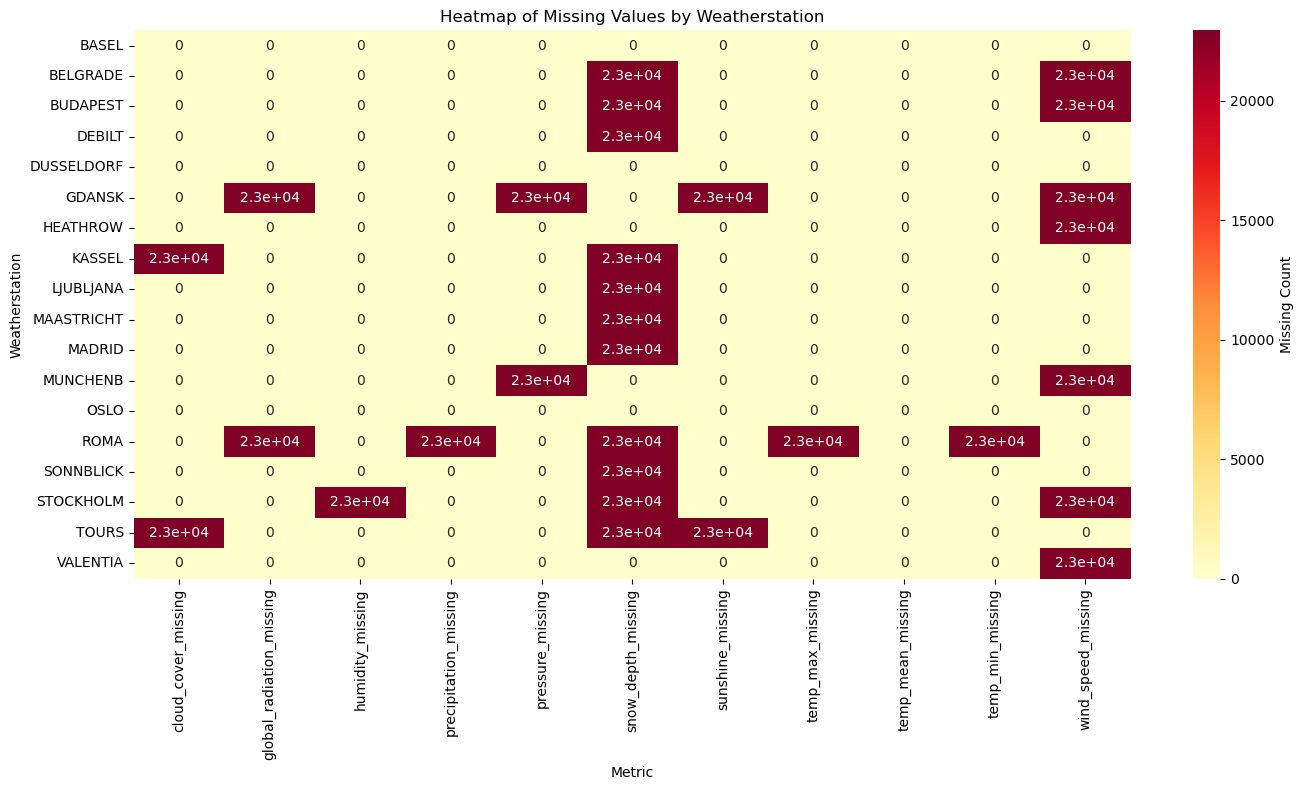

In [34]:
# Set the weatherstation as the index for better visualization
nc_indexed = nc.set_index('weatherstation')

# Select only the columns related to missingness
missing_cols = [
    'cloud_cover_missing', 'global_radiation_missing', 'humidity_missing',
    'precipitation_missing', 'pressure_missing', 'snow_depth_missing',
    'sunshine_missing', 'temp_max_missing', 'temp_mean_missing',
    'temp_min_missing', 'wind_speed_missing'
]

a = plt.figure(figsize=(14, 8))
sns.heatmap(nc_indexed[missing_cols], annot=True, cmap='YlOrRd', cbar_kws={'label': 'Missing Count'})
plt.title('Heatmap of Missing Values by Weatherstation')
plt.xlabel('Metric')
plt.ylabel('Weatherstation')
plt.tight_layout()
plt.show()


In [35]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/heatmap_weather_metrics_missing.png'
a.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/heatmap_weather_metrics_missing.png


---

### ❓ Hypothesis: Unlocking Weather’s Emergent Patterns with ML

**The Challenge:**
The historical temperature trends visualized below reveal broad patterns—such as annual cycles and increasing winter variability—but they struggle to explain the intra-annual “spikes and dips” that defy simple trend-following.

**The Hypothesis:**
Machine Learning models trained on extensive historical weather metrics can uncover emergent, non-obvious relationships between variables. By detecting nonlinear, multivariate patterns that elude visual inspection, ML holds the potential to improve predictive accuracy beyond what simple temporal proximity can achieve.

---

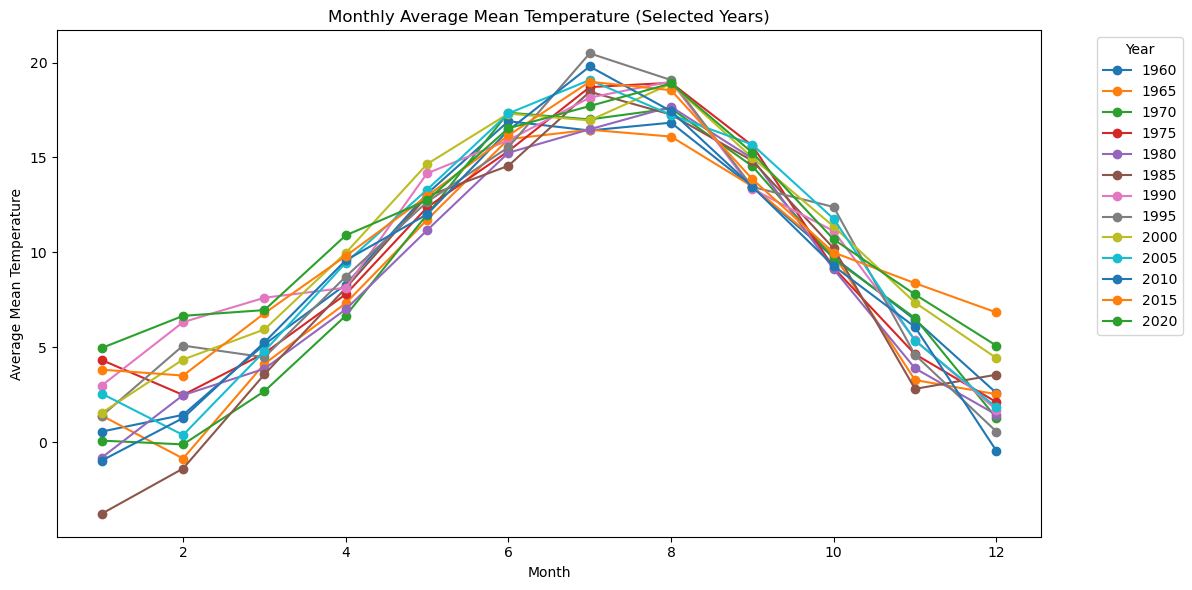

In [37]:
# Get unique years and select every 7th year (starting from the first)
years = np.sort(normalized['year'].unique())
selected_years = years[::5]  # Adjust the stride as needed

# Filter data for selected years
filtered = normalized[normalized['year'].isin(selected_years)]

# Group and pivot as before
monthly_avg = (
    filtered
    .groupby(['year', 'month'])['temp_mean']
    .mean()
    .reset_index()
)
pivot = monthly_avg.pivot(index='month', columns='year', values='temp_mean')

# Plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))
pivot.plot(ax=ax, marker='o')
ax.set_xlabel('Month')
ax.set_ylabel('Average Mean Temperature')
ax.set_title('Monthly Average Mean Temperature (Selected Years)')
ax.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [38]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/timeseries_tempmean.png'
fig.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/timeseries_tempmean.png


### ❓ Hypothesis: Feature Interdependencies as Predictive Signals

**Observations:**
Correlated feature groupings (**see: correlation matrix below**) suggest latent relationships that could carry predictive power:

* **Positively correlated clusters:**

  * Cloud cover, humidity, and precipitation
  * Global radiation, sunshine, and temperatures (mean, max, min)

* **Negatively correlated pairs:**

  * Humidity ↔ Sunshine
  * Cloud cover ↔ Sunshine

**Hypothesis:**
Machine Learning models may be able to exploit these **feature interdependencies**—particularly among tightly coupled variables like humidity, cloud cover, and precipitation—as **composite predictive signals**.
By capturing how these features move together, models may achieve greater predictive accuracy than they would using isolated variables alone.

---

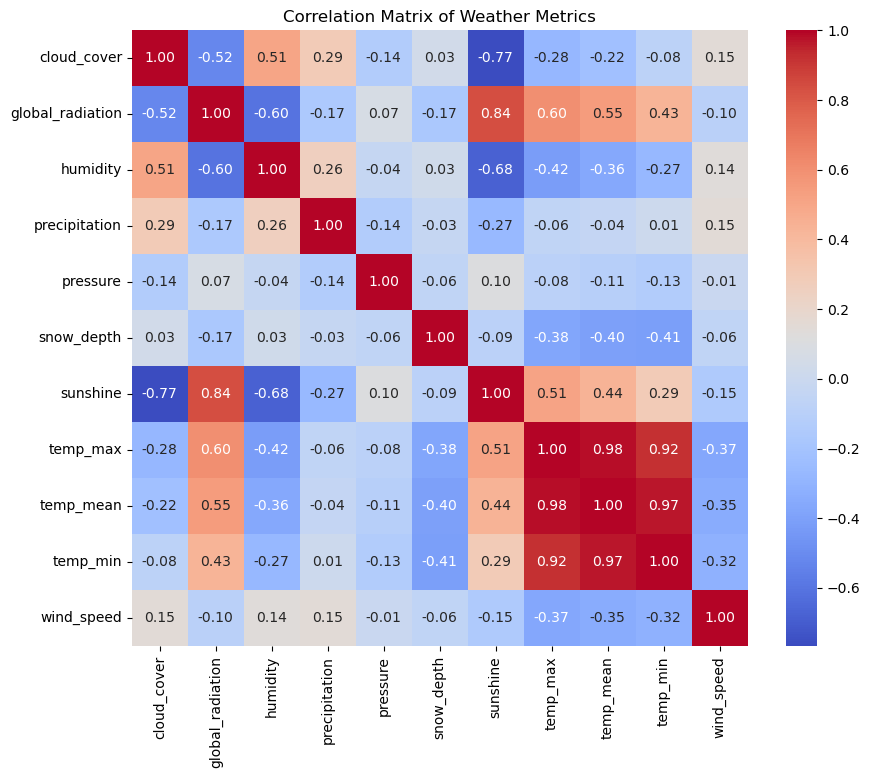

In [40]:
weather_metrics = [
    'cloud_cover', 'global_radiation', 'humidity', 'precipitation', 'pressure',
    'snow_depth', 'sunshine', 'temp_max', 'temp_mean', 'temp_min', 'wind_speed'
]

# Calculate correlation matrix
corr_matrix = normalized[weather_metrics].corr()

# Plot heatmap
cm = plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Weather Metrics')
plt.show()


In [41]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/corr_matrix_weather_metrics.png'
cm.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/corr_matrix_weather_metrics.png


---
### ❓ Hypothesis: Temporal Drift in Weather Dynamics

**Observation:**
Box plot visualizations of yearly-aggregated weather metrics reveal notable distributional shifts over time. For example, recent years display:

* **Rising temperatures**
* **Declining snowfall**
* **Historical values increasingly flagged as outliers**

These trends visually indicate the emergence of **“new normals,”** as formerly typical values now sit at the extremes of current distributions—a clear statistical signature of long-term climate change.

**Hypothesis:**
As climate change alters the distribution of key weather variables, their underlying statistical properties experience **temporal drift**.
This poses a risk to machine learning models trained on historical data: patterns learned from past conditions may become **less predictive** over time, degrading model performance on recent or future inputs unless the drift is explicitly addressed.

---


In [43]:
### ✅ Aggregate observations to the YEAR level; find their averages. 

# Convert 'date' column to datetime, just in case
normalized['date'] = pd.to_datetime(normalized['date'])

# Extract year and month from the datetime column
normalized['year'] = normalized['date'].dt.year
normalized['month'] = normalized['date'].dt.month

# Group by year, month, weather station, and compute mean of the metrics
weather_metrics = [
    'cloud_cover', 'global_radiation', 'humidity', 'precipitation', 'pressure',
    'snow_depth', 'sunshine', 'temp_max', 'temp_mean', 'temp_min', 'wind_speed'
]

aggregated = (
    normalized
    .groupby(['year', 'month', 'weatherstation'])[weather_metrics]
    .mean()
    .reset_index()
)


<bound method Axes.set of <Axes: title={'center': 'Box Plot of Weather Metrics with Time-Colored Outliers'}, ylabel='Normalized Value'>>

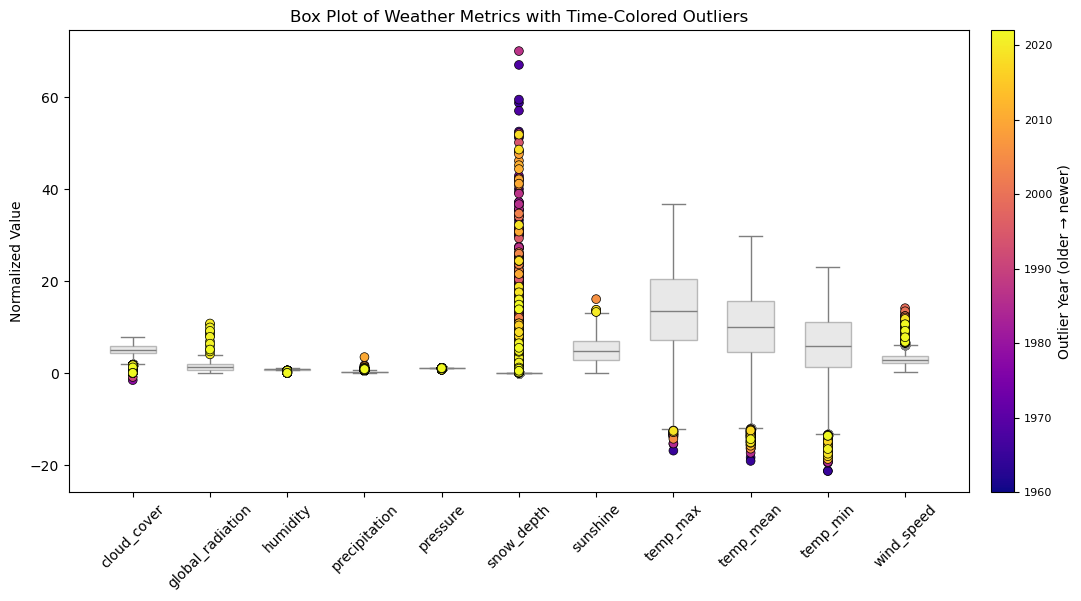

In [44]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Assume 'normalized' has a datetime index or a 'year' column
if 'year' not in aggregated.columns:
    aggregated['year'] = aggregated.index.year

weather_metrics = [
    'cloud_cover', 'global_radiation', 'humidity', 'precipitation', 'pressure',
    'snow_depth', 'sunshine', 'temp_max', 'temp_mean', 'temp_min', 'wind_speed'
]

fig, ax = plt.subplots(figsize=(14, 6))

# Create a color map for years
norm = Normalize(vmin=aggregated['year'].min(), vmax=aggregated['year'].max())
cmap = plt.cm.plasma  # or viridis, coolwarm, etc.

# Store x positions for each metric
for i, metric in enumerate(weather_metrics):
    data = aggregated[[metric, 'year']].dropna()
    values = data[metric].values
    years = data['year'].values
    
    # Compute boxplot stats manually
    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Split data
    regular = values[(values >= lower_bound) & (values <= upper_bound)]
    outliers = values[(values < lower_bound) | (values > upper_bound)]
    outlier_years = years[(values < lower_bound) | (values > upper_bound)]

    # Plot regular data as box
    sns.boxplot(y=metric, x=[i]*len(regular), data=pd.DataFrame({metric: regular}), ax=ax, width=0.6, color='lightgray', boxprops=dict(alpha=0.5))

    # Plot outliers manually
    scatter = ax.scatter(
        [i]*len(outliers), outliers,
        c=outlier_years,
        cmap=cmap,
        norm=norm,
        edgecolor='black',
        linewidth=0.5,
        s=40,
        zorder=5
    )

# Add colorbar legend for outlier years
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Outlier Year (older → newer)', fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Set x-tick labels
ax.set_xticks(range(len(weather_metrics)))
ax.set_xticklabels(weather_metrics, rotation=45)
ax.set_title('Box Plot of Weather Metrics with Time-Colored Outliers')
ax.set_ylabel('Normalized Value')
ax.set


In [45]:
# Save the plot
save_path = f'/Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/boxplot_agg_weather_metrics.png'
fig.savefig(save_path, dpi=300, bbox_inches='tight')

# Confirmation
print(f'✅ Saved: {save_path}')

✅ Saved: /Users/amyzhang/Desktop/AZ_ClimateWins_2025/Visualizations/boxplot_agg_weather_metrics.png


# 4. Preparing `pleasant_weather` Dataset for SQL Export

ClimateWins aims to use machine learning to predict **“pleasant weather”** conditions, using a simplified dataset with binary labels:

* `1` = Pleasant
* `0` = Unpleasant

These binary values will serve as the **target variable (`y`)** in our supervised machine learning models, which will be trained on corresponding weather features (`X`).


## Import dataset

In [48]:
# Path to your csv file
csv_file_path = '/Users/amyzhang/Desktop/AZ_ClimateWins_2025/pleasant_weather_Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv'

# Import 
pleasant_weather = pd.read_csv(csv_file_path)  

# Verify the import
print(pleasant_weather.shape)
print(pleasant_weather.dtypes.to_string())

(22950, 16)
DATE                           int64
BASEL_pleasant_weather         int64
BELGRADE_pleasant_weather      int64
BUDAPEST_pleasant_weather      int64
DEBILT_pleasant_weather        int64
DUSSELDORF_pleasant_weather    int64
HEATHROW_pleasant_weather      int64
KASSEL_pleasant_weather        int64
LJUBLJANA_pleasant_weather     int64
MAASTRICHT_pleasant_weather    int64
MADRID_pleasant_weather        int64
MUNCHENB_pleasant_weather      int64
OSLO_pleasant_weather          int64
SONNBLICK_pleasant_weather     int64
STOCKHOLM_pleasant_weather     int64
VALENTIA_pleasant_weather      int64


In [49]:
pleasant_weather.head()

,DATE,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
0,19600101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,19600102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,19600103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,19600104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,19600105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Transform from wide to long format

In [51]:
# 1. Identify id_vars and value_vars
id_vars = ['DATE']  # columns that are not city-specific

# 2. Melt the DataFrame
melted_pw = pd.melt(
    pleasant_weather,
    id_vars=id_vars,
    var_name='weatherstation_metric',
    value_name='value'
)

# 3. Split 'city_metric' into 'city' and 'metric'
melted_pw[['WEATHERSTATION', 'METRIC']] = melted_pw['weatherstation_metric'].str.extract(r'([^_]+)_(.+)')

# 4. Pivot so each metric becomes its own column
normalized_pw = melted_pw.pivot_table(
    index=['DATE', 'WEATHERSTATION'],
    columns='METRIC',
    values='value'
).reset_index()

# Optional: Flatten columns if needed
normalized_pw.columns.name = None


In [52]:
normalized_pw.head()

,DATE,WEATHERSTATION,pleasant_weather
0,19600101,BASEL,0.0
1,19600101,BELGRADE,0.0
2,19600101,BUDAPEST,0.0
3,19600101,DEBILT,0.0
4,19600101,DUSSELDORF,0.0


## Parsing and Enriching Date Column

In [54]:
# Suppose your DataFrame is df and DATE is an int (e.g., 19600101)
normalized_pw['DATE'] = normalized_pw['DATE'].astype(str)  # Convert to string
normalized_pw['date_parsed'] = pd.to_datetime(normalized_pw['DATE'], format='%Y%m%d')  # Parse to datetime
normalized_pw['year'] = normalized_pw['date_parsed'].dt.year

# Optional: Add day name for clarity
normalized_pw['day_name'] = normalized_pw['date_parsed'].dt.day_name()


## Enriching Location Data: Mapping Weather Stations to Country

In [56]:
weatherstation_to_country = {
    'BASEL': 'Switzerland',
    'BELGRADE': 'Serbia',
    'TOURS': 'France',
    'STOCKHOLM': 'Sweden',
    'SONNBLICK': 'Austria',
    'ROMA': 'Italy',
    'OSLO': 'Norway',
    'MUNCHENB': 'Germany',
    'MADRID': 'Spain',
    'MAASTRICHT': 'Netherlands',
    'LJUBLJANA': 'Slovenia',
    'KASSEL': 'Germany',
    'HEATHROW': 'United Kingdom',
    'GDANSK': 'Poland',
    'DUSSELDORF': 'Germany',
    'DEBILT': 'Netherlands',
    'BUDAPEST': 'Hungary',
    'VALENTIA': 'Ireland'
}

# If your DataFrame has a 'CITY' column:
normalized_pw['COUNTRY'] = normalized_pw['WEATHERSTATION'].map(weatherstation_to_country)


In [57]:
normalized_pw.head()

,DATE,WEATHERSTATION,pleasant_weather,date_parsed,year,day_name,COUNTRY
0,19600101,BASEL,0.0,1960-01-01,1960,Friday,Switzerland
1,19600101,BELGRADE,0.0,1960-01-01,1960,Friday,Serbia
2,19600101,BUDAPEST,0.0,1960-01-01,1960,Friday,Hungary
3,19600101,DEBILT,0.0,1960-01-01,1960,Friday,Netherlands
4,19600101,DUSSELDORF,0.0,1960-01-01,1960,Friday,Germany


## Format for SQL Export

In [59]:
### Check if dtypes need to be redefined.
normalized_pw.dtypes

DATE                        object
WEATHERSTATION              object
pleasant_weather           float64
date_parsed         datetime64[ns]
year                         int32
day_name                    object
COUNTRY                     object
dtype: object

In [60]:
### Redefine 'pleasant_weather' as BOOLEAN
normalized_pw['pleasant_weather'] = normalized_pw['pleasant_weather'].astype(bool)

### Lowercase

normalized_pw.columns = [col.lower() for col in normalized_pw.columns]

### Concatenate location

normalized_pw['weatherstation_country'] = (
    normalized_pw['weatherstation'].astype(str) + '_' + normalized_pw['country'].astype(str)
)


### Re-order

cols = [
    'date', 'date_parsed', 'year', 'day_name',
    'weatherstation', 'country', 'weatherstation_country', 'pleasant_weather'
]
normalized_pw = normalized_pw[cols]



In [61]:
### Confirm BOOL
normalized_pw.dtypes

date                              object
date_parsed               datetime64[ns]
year                               int32
day_name                          object
weatherstation                    object
country                           object
weatherstation_country            object
pleasant_weather                    bool
dtype: object

In [62]:
# Export data to csv
path = '/Users/amyzhang/Desktop/AZ_ClimateWins_2025/Datasets'
output_file = 'pleasant_weather_post_unmelt.csv'
full_path = os.path.join(path, output_file)

# Save the dataframe
normalized_pw.to_csv(full_path, index=False)

# Check if the file was created successfully
if os.path.exists(full_path):
    print(f"Saving confirmed: '{output_file}' has been created successfully.")
else:
    print("Error: File was not saved.")

Saving confirmed: 'pleasant_weather_post_unmelt.csv' has been created successfully.


## Import to SQL
```
CREATE TABLE pleasant_weather(
    date TEXT,
    date_parsed TIMESTAMP,
    year INTEGER,
    day_name TEXT,
    weatherstation TEXT,
    country TEXT,
    weatherstation_country TEXT,
    pleasant_weather BOOLEAN
);
```

# 5. Basic Exploratory Data Analysis of `pleasant_weather`

*More extensive visual analysis conducted in Tableau.*

* **Date Range:** Same as the full weather dataset (1960–2022), but with the same issue of year-to-year observation irregularity.

* **Geographic Coverage:**
  Three cities—**Tours (France), Roma (Italy), and Gdańsk (Poland)**—are **excluded** from the `pleasant_weather` dataset.

  
  ⚠️ *Ethical Concern:* Even at this micro-scale, we begin to see the issue of **uneven spatial representation**, which foreshadows the broader problem of **global bias** in climate datasets.

* **Class Imbalance (Target Variable):**

  ```
  pleasant_weather (boolean)
  0.0    270,234
  1.0     74,016
  ```

  This reflects a **\~3.6:1 imbalance**, with “unpleasant” days dominating. While such an imbalance may accurately reflect real-world weather conditions, it prompts a deeper question:

  ⚠️ *Ethical Concern: Subjectivity in Labeling*
The binary label of “pleasantness” encodes **narrow, implicit thresholds**—likely based on temperature, sunshine, and precipitation—that reflect **culturally situated norms** of comfort.

Machine learning models trained on these labels risk reinforcing normative assumptions (e.g., *“warm and sunny = good”*) that may:

* Misrepresent comfort across diverse **European climates** (e.g., Nordic vs. Mediterranean regions)
* **Bias user behavior**, such as tourists avoiding areas deemed “unpleasant”
* Be **repurposed in downstream applications** (e.g., real estate, urban planning), contributing to **resource neglect** in already-vulnerable regions

In [65]:
normalized_pw.head()

,date,date_parsed,year,day_name,weatherstation,country,weatherstation_country,pleasant_weather
0,19600101,1960-01-01,1960,Friday,BASEL,Switzerland,BASEL_Switzerland,False
1,19600101,1960-01-01,1960,Friday,BELGRADE,Serbia,BELGRADE_Serbia,False
2,19600101,1960-01-01,1960,Friday,BUDAPEST,Hungary,BUDAPEST_Hungary,False
3,19600101,1960-01-01,1960,Friday,DEBILT,Netherlands,DEBILT_Netherlands,False
4,19600101,1960-01-01,1960,Friday,DUSSELDORF,Germany,DUSSELDORF_Germany,False


## Missing Geographic Coverage 

In [67]:
weather_stations_set = set(normalized['weatherstation'].unique())
pleasant_weather_set = set(normalized_pw['weatherstation'].unique())

matching_weatherstations = weather_stations_set.intersection(pleasant_weather_set)
num_matching = len(matching_weatherstations)
print(f"Number of matching weather stations: {num_matching}")

missing_in_pleasant = weather_stations_set - pleasant_weather_set
print(f"Missing weather stations from pleasant_weather: {missing_in_pleasant}")

missing_in_weather = pleasant_weather_set - weather_stations_set
print(f"Missing weather stations from weather_df: {missing_in_weather}")

Number of matching weather stations: 15
Missing weather stations from pleasant_weather: {'GDANSK', 'ROMA', 'TOURS'}
Missing weather stations from weather_df: set()


## Recording Date Inconsistencies

In [69]:
# Finding Date Range
min_date_pw = normalized_pw['year'].min()
max_date_pw = normalized_pw['year'].max()

print(f"Minimum Date: {min_date}")
print(f"Maximum Date: {max_date}")

Minimum Date: 1960
Maximum Date: 2022


In [70]:
normalized_pw['year'].value_counts()

year
1960    5490
2016    5490
1980    5490
2008    5490
2004    5490
        ... 
1989    5475
1990    5475
1961    5475
1993    5475
2022    4560
Name: count, Length: 63, dtype: int64

## Class Imbalance & The Spectre of Subjectivity 😶‍🌫️

In [72]:
normalized_pw['pleasant_weather'].value_counts()

pleasant_weather
False    270234
True      74016
Name: count, dtype: int64

In [73]:
pleasant_counts = (
    normalized_pw[normalized_pw['pleasant_weather'] == 1]
    .groupby('country')
    .size()
    .sort_values(ascending=False)
)
print("Countries by most to least pleasant weather days:")
print(pleasant_counts)


Countries by most to least pleasant weather days:
country
Germany           13475
Spain             10247
Netherlands        9225
Serbia             7992
Hungary            7431
Slovenia           6376
Switzerland        5664
United Kingdom     4959
Sweden             3894
Norway             3579
Ireland            1174
dtype: int64


In [74]:
unpleasant_counts = (
    normalized_pw[normalized_pw['pleasant_weather'] == 0]
    .groupby('country')
    .size()
    .sort_values(ascending=False)
)
print("Countries by most to least unpleasant weather days:")
print(unpleasant_counts)


Countries by most to least unpleasant weather days:
country
Germany           55375
Netherlands       36675
Austria           22950
Ireland           21776
Norway            19371
Sweden            19056
United Kingdom    17991
Switzerland       17286
Slovenia          16574
Hungary           15519
Serbia            14958
Spain             12703
dtype: int64


# ✅ Summary & Next Steps

In this notebook, we completed foundational data processing and exploratory analysis of both the weather dataset and the binary-labeled “pleasant weather” subset. Along the way, we flagged potential ethical concerns around class imbalance, cultural subjectivity, missingness, and temporal bias.

> 🌱 **Next Step:** In the following notebook, we take a step back to explore how machines can *learn patterns from data.*

While not intended as a production-ready model, the upcoming **univariate linear regression demo** introduces a core concept in machine learning:
**Gradient Descent**—the process by which an algorithm *adjusts its own parameters* to improve performance based on error feedback.

For organizations like *ClimateWins*, which aim to **anticipate and adapt to shifting climate conditions**, this ability to self-adjust is key. ML models that iterate over vast inputs and tune themselves systematically offer a path toward smarter, faster, and more adaptive climate tools—far beyond what manual human tuning can achieve.